In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
import pickle

with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    
final_dict = {}
game_names = set()
min_trails = 10000

for timeslot in loaded_dict.keys():
    final_dict[timeslot] = {}
    for game in loaded_dict[timeslot].keys():
        if loaded_dict[timeslot][game].shape[0] > 6:
            if loaded_dict[timeslot][game].shape[0] < min_trails:
                min_trails = loaded_dict[timeslot][game].shape[0]

            game_names.add(game)
            final_dict[timeslot][game] = loaded_dict[timeslot][game]

games_index_to_name_mapping = {
    
}

for i in range(0, len(game_names)):
    games_index_to_name_mapping[i] = list(game_names)[i]

In [3]:
def generate_metrics(df):
    df = df.copy()
    df['target_mean_viewer_count_growth'] = (df['target_mean_viewer_count_3'] - df['mean_viewer_count']) / (df['mean_viewer_count'] + 1e-5)
    df['target_median_viewer_count_growth'] = (df['target_median_viewer_count_3'] - df['median_viewer_count']) / (df['median_viewer_count'] + 1e-5)
    
    df['target_is_short_stream'] = df['target_median_stream_duration_hours_3'].apply(lambda row: 1 if row <= 1 else 0)
    
    df['target_is_medium_stream'] = df['target_median_stream_duration_hours_3'].apply(lambda row: 1 if row <= 3 and row > 1 else 0)
    df['target_is_long_stream'] = df['target_median_stream_duration_hours_3'].apply(lambda row: 1 if row > 3 else 0)
    df['target_is_mature'] = df['target_is_mature_3']
    return df


In [4]:
context_features_list = [
    'mean_viewer_count',
    'median_viewer_count',
    'total_viewer_count',
    'mean_stream_duration_hours',
    'median_stream_duration_hours',
    'total_stream_duration_hours',
    'is_mature',
    'mean_positive_sentiment',
    'mean_negative_sentiment',
    'mean_neutral_sentiment'
]

indx_to_reward_str_mapping = {
    0 :'target_mean_viewer_count_growth',
    1 :'target_median_viewer_count_growth',
    2 :'target_is_short_stream',
    3 : 'target_is_medium_stream',
    4 : 'target_is_long_stream',
    5 : 'target_is_mature'
}

def calculate_reward(row, preference, indx_to_reward_str_mapping):
    reward_vector = np.array([0.0] * len(preference))
    
    for objective in indx_to_reward_str_mapping.keys():
        reward_vector[objective] = row[indx_to_reward_str_mapping[objective]]
        if reward_vector[objective] <= 0:
            reward_vector[objective] = 0
    
    reward = np.dot(reward_vector, preference)
    return reward

def get_oracle_value_for_day(df):
    return np.max(df['reward'])

/Users/parthpahwa/miniforge3/lib/python3.9/site-packages/numpy/core/numeric.py:936: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


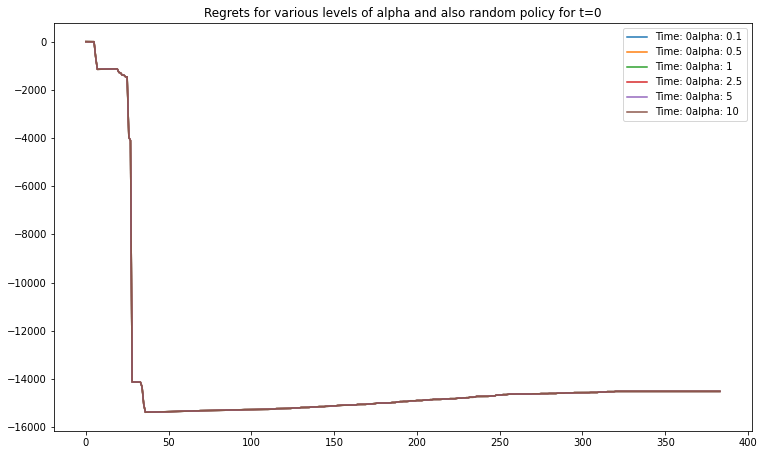

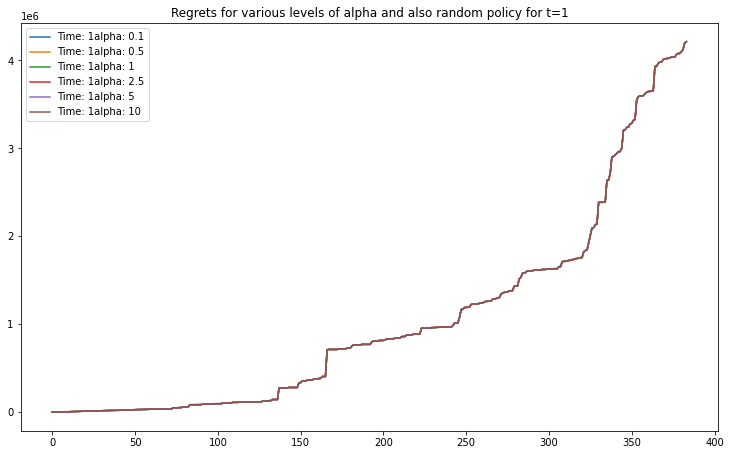

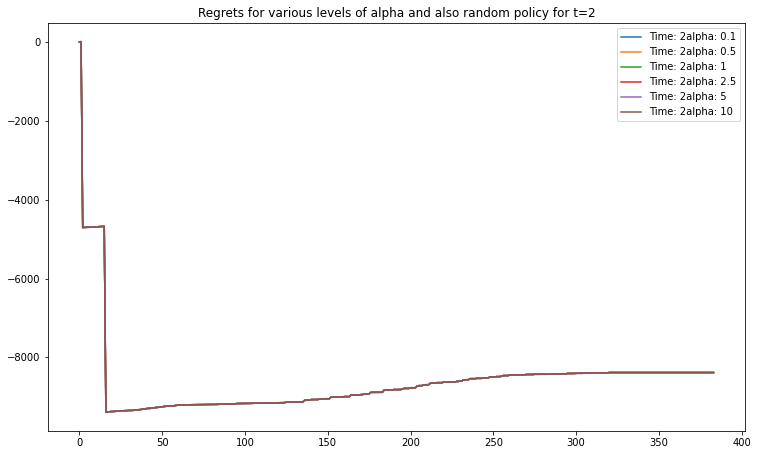

/Users/parthpahwa/miniforge3/lib/python3.9/site-packages/numpy/core/numeric.py:936: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/var/folders/zd/kdgn2w_s28q2d2gnvdb0dd6w0000gn/T/ipykernel_67676/4048603891.py:40: RuntimeWarning: overflow encountered in multiply
  b[chosen_arm] += r_payoffs[t]*x_chosen_arm # update the b values for each features corresponding to the pay off and the features of the chosen_arm


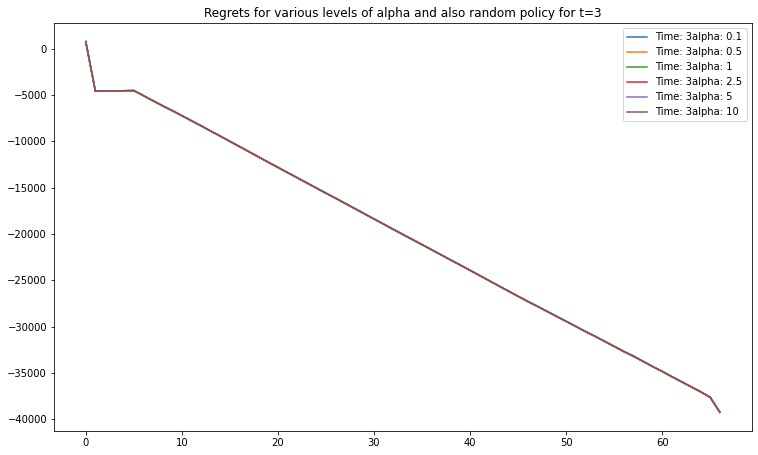

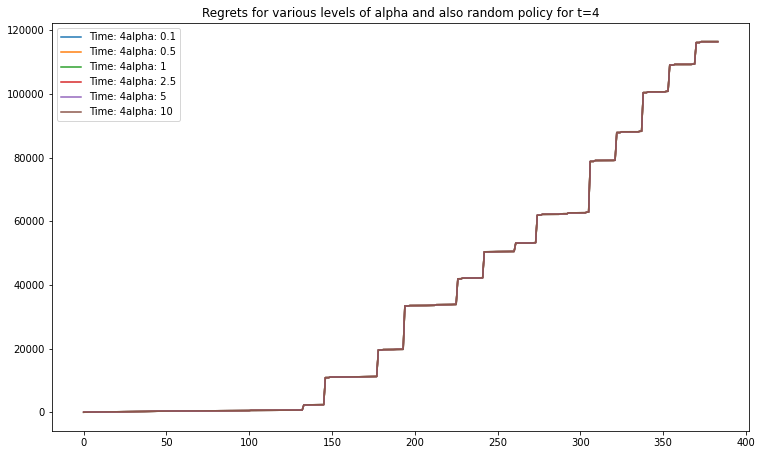

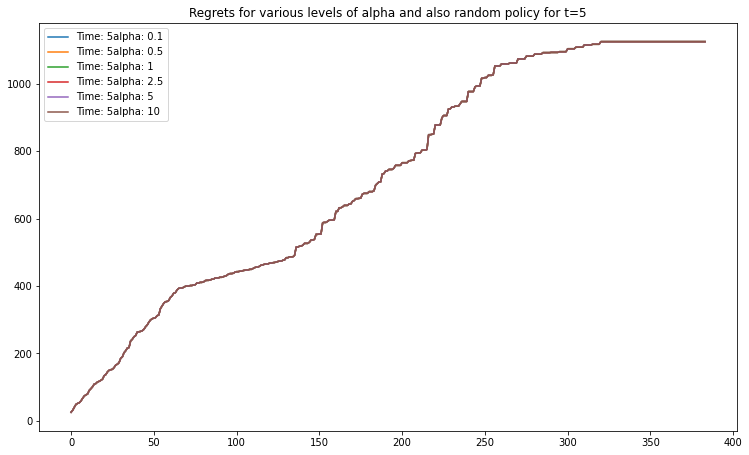

In [143]:
num_preferences = 6
alphas = [0.1, 0.5, 1, 2.5, 5, 10]

def generate_random_preference(num_preferences):
    return np.random.dirichlet(np.ones(num_preferences))


for time_split in final_dict.keys():
    nArms = len(game_names)
    
    num_preferences_to_simulate = 64
    n_trials = (min_trails - 1)
    
    preference = np.array([1, 0., 0, 0,0,0])
    
    
    X = [None] * len(games_index_to_name_mapping)
    REWARD = [None] * len(games_index_to_name_mapping)
    
    FINAL_DATA = np.empty(
        shape=(
            n_trials*num_preferences_to_simulate, 
            nArms, 
            len(preference) + len(context_features_list)
        )
    )
    
    REWARD_MATRIX = np.empty(shape=(n_trials*num_preferences_to_simulate, nArms))
    ORACLE = np.empty(shape=(n_trials*num_preferences_to_simulate))
    
    for preference_num in range(num_preferences_to_simulate):
        preference = generate_random_preference(num_preferences)
        
        df_for_train = None
    
        for game_name in final_dict[time_split].keys():
            temp_df = generate_metrics(final_dict[time_split][game_name])
            temp_df['reward'] = temp_df.apply(lambda row: calculate_reward(row, preference, indx_to_reward_str_mapping), axis=1)

            if df_for_train is None:
                df_for_train = temp_df
            else:
                df_for_train = pd.concat([df_for_train, temp_df])

        df_for_train['oracle_value'] = df_for_train.groupby(['log_date'])['reward'].transform(max)
        
        for i in range(len(games_index_to_name_mapping)):


            X[i] = df_for_train[df_for_train['game_name'] == games_index_to_name_mapping[i]][context_features_list].to_numpy()
            REWARD[i] = df_for_train[df_for_train['game_name'] == games_index_to_name_mapping[i]][['reward']].to_numpy()
            MAX_REWARD = df_for_train[df_for_train['game_name'] == games_index_to_name_mapping[i]][['oracle_value']].to_numpy()


            if X[i].shape[0] > 0:

                X[i] = np.concatenate((X[i], preference.reshape(1,-1).repeat(X[i].shape[0], axis=0)), axis=1)

                for trails in range(n_trials):
                    FINAL_DATA[(preference_num+1)*trails][i] = X[i][trails]
                    REWARD_MATRIX[(preference_num+1)*trails][i] = REWARD[i][trails]
                    ORACLE[(preference_num+1)*trails] = MAX_REWARD[trails]
    
    results_dict = {
        alpha: lin_ucb(
            alpha=alpha,
            X = FINAL_DATA,
            n_arms = nArms,
            REWARD_MATRIX = REWARD_MATRIX
        ) 
        for alpha in alphas
    }
    
    def plot_regrets(results, oracles, time_slot):
        [plt.plot(make_regret(payoffs=x['r_payoffs'], oracles=oracles), label="Time: " + str(time_slot) +
                  "alpha: " + str(alpha)) for (alpha, x) in results.items()]

    plt.figure(figsize=(12.5, 7.5))
    plot_regrets(results_dict, ORACLE, time_split)
    # plot also the random one
    plt.legend()
    plt.title("Regrets for various levels of alpha and also random policy for t="+ str(time_split))
    plt.show()


# final_df = generate_features(df)
# alphas = [0.1, 0.5, 1, 2.5, 5, 10]
# results_dict = {
#     alpha: lin_ucb(alpha=alpha, 
#                    X = final_df[feature_vector].to_numpy(),
#                    n_arms = 3,
#                    generate_reward=generate_reward, 
#                    optimal_action = final_df['arm_choice'].to_numpy()) 
#     for alpha in alphas
# }

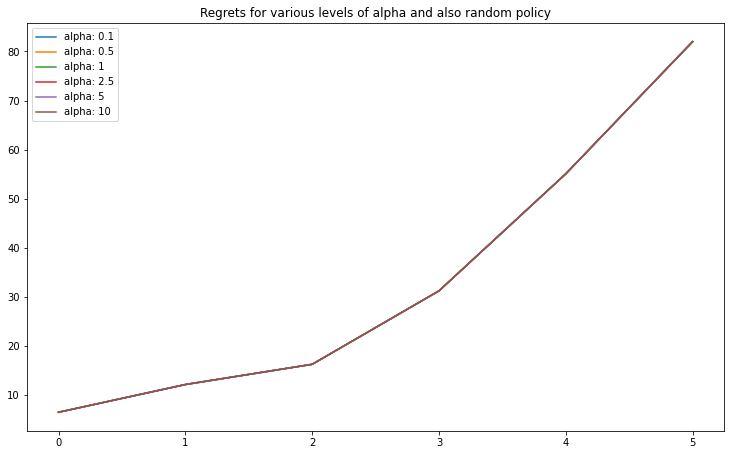

In [4]:
def make_regret(payoffs, oracles):
    """
    Generate the cummulative regret over time.
    Parameters:
    -----------
        payoffs: an array of T payoffs (for T number of trials)
        oracles: an array of best values for T trials (oracles)
    Returns:
        Array of the cumulative sum over time (of size T = number of trials)
    """
    
    return np.cumsum(oracles - payoffs)

In [128]:
def lin_ucb(alpha, X, n_arms, REWARD_MATRIX):
    """
    Simulate the LINUCB algorithm using the generated data X.
    Parameters:
    -----------
        alpha: this is the ::math:`\alpha = \sqrt{ln(2/\sigma)/2}`
        X: is the observed data (contexts for all arms at every trial)
        generate_reward: a function used to generate the reward for an arm given a context and a theta
        true_theta: the true theta used to generate the oracles and compare the losses (regrets)
    """
    
    # Data storages
    n_trials, n_arms, n_features = X.shape
    arm_choice = np.empty(n_trials) # used to store agent's choices for each trial
    r_payoffs = np.empty(n_trials) # used to store the payoff for each trial (the payoff for the selected arm based on the true_theta)
    
    theta = np.empty(shape=(n_trials, n_arms, n_features)) # used to store the predicted theta over each trial
    p = np.empty(shape=(n_trials, n_arms)) # used to store predictions for reward of each arm for each trial
    
    # Lin UCB Objects
    A = np.array([np.diag(np.ones(shape=n_features)) for _ in np.arange(n_arms)]) # A is the matrix defined as :math:A_a = D_a^TD_a + I_d, and for the initialization it is I_d and will be updated after every trial
    b = np.array([np.zeros(shape=n_features) for _ in np.arange(n_arms)]) # b is the matrix defined as response vectors (reward for each feature for each arm at each trial, initialized to zero for all features of all arms at every trial)
    
    # The algorithm
    for t in range(n_trials):
        # compute the estimates (theta) and prediction (p) for all arms
        for a in range(n_arms):
            inv_A = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a]) # estimate theta as from this formula :math:`\hat{\theta}_a = A_a^{-1}b_a`
            p[t, a] = theta[t, a].dot(X[t, a]) + alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a])) # predictions is the expected mean + the confidence upper bound
        
        # choosing the best arms
        chosen_arm = np.argmax(p[t])
        x_chosen_arm = X[t, chosen_arm]
        r_payoffs[t] = REWARD_MATRIX[t, chosen_arm] # This payoff is for the predicted chosen arm, and but the payoff is based on theoretical theta (true theta)
        arm_choice[t] = chosen_arm
        
        # Update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoffs[t]*x_chosen_arm # update the b values for each features corresponding to the pay off and the features of the chosen_arm
    
    return dict(theta=theta, p=p, arm_choice=arm_choice, r_payoffs = r_payoffs)

In [72]:
feature_vector = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6']

In [73]:
def plot_regrets(results, oracles):
    [plt.plot(make_regret(payoffs=x['r_payoffs'], oracles=oracles), label="alpha: " + str(alpha)) for (alpha, x) in results.items()]


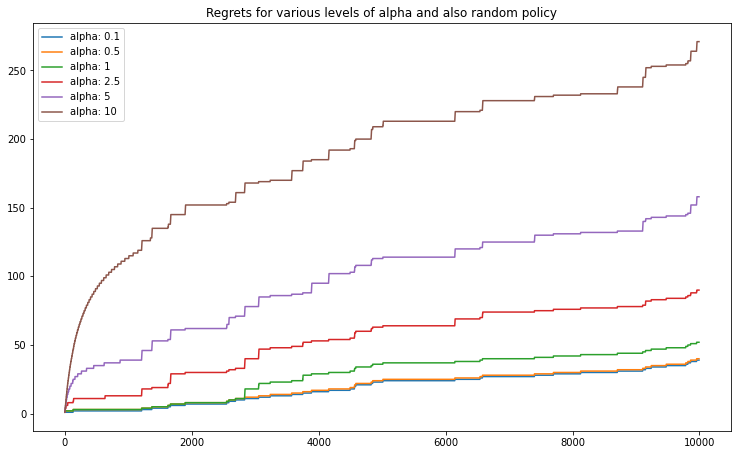

In [80]:
df = generate_sequence(10000, 3, np.array([0.1, 50.1, 0.1]))
final_df = generate_features(df)
alphas = [0.1, 0.5, 1, 2.5, 5, 10]
results_dict = {
    alpha: lin_ucb(alpha=alpha, 
                   X = final_df[feature_vector].to_numpy(),
                   n_arms = 3,
                   generate_reward=generate_reward, 
                   optimal_action = final_df['arm_choice'].to_numpy()) 
    for alpha in alphas
}

plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, np.ones(final_df.shape[0]))
# plot also the random one
plt.legend()
plt.title("Regrets for various levels of alpha and also random policy")
plt.show()


In [83]:
final_df

,sequence_number,arm_choice,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
6,6,1,1.0,1.0,1.0,1.0,1.0,1.0
7,7,1,1.0,1.0,1.0,1.0,1.0,1.0
8,8,1,1.0,1.0,1.0,1.0,1.0,1.0
9,9,1,1.0,1.0,1.0,1.0,1.0,1.0
10,10,1,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
9995,9995,1,1.0,1.0,1.0,1.0,1.0,1.0
9996,9996,1,1.0,1.0,1.0,1.0,1.0,1.0
9997,9997,1,1.0,1.0,1.0,1.0,1.0,1.0
9998,9998,1,1.0,1.0,1.0,1.0,1.0,1.0
